In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Model packages
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_validate

In [3]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Data Cleaning

In [4]:
months = ['January', 'February', 'March',
          'April', 'May', 'June', 'July',
          'August', 'September', 'October',
          'November', 'December']
def classify_month(x):
    return months.index(x) // 3

from nltk import word_tokenize
from nltk import pos_tag


# Tokenize Property type, get nouns in order to reduce unique categories
keys = np.unique(np.concatenate([train['Property_type'],test['Property_type']]))
vals = [[w[0] for w in pos_tag([word for word in word_tokenize(doc.lower().replace('/',' ')) if word.isalpha()]) if w[1] == 'NN' and w[0] != 'room'] for doc in keys]
uni_vals = np.unique(['room'] + [' '.join(v) for v in vals])

val_dict = {}
for i, v in enumerate(uni_vals):
    val_dict[v] = i

property_dict = {}
for i, k in enumerate(keys):
    if len(vals[i]) == 0:
        property_dict[k] = val_dict['room']
    else:
        property_dict[k] = val_dict[' '.join(vals[i])]


# Tokenize Bathroom type, get nouns in order to reduce unique categories

def clean_bathroom(X):
    clean = [[w[0] for w in pos_tag(word_tokenize(doc.lower())) if w[1] == 'CD' or w[1] == 'NN' or w[1] == 'NNS'] for doc in X]
    return [0.5 if len(doc) == 1 else doc[0] for doc in clean] #map half-bath to 0.5

key = np.concatenate([train['Bathrooms_text'].unique(), test['Bathrooms_text'].unique()])
bath = clean_bathroom(key)

bath_dict = {}
for i, k in enumerate(key):
    bath_dict[k] = bath[i]


def CLEAN_ALL(inp, train = True, exclude_columns = ['id']):
    X_train = inp.copy()
    
    if train:
        X_train, y_train = X_train.drop('Decision', axis = 1), X_train['Decision']

    # DATA CLEANING
    if 'Price' not in exclude_columns:
        X_train['Price'] = X_train['Price'].apply(lambda x: float(x.replace('$','').replace(',','')))
        
    if 'Host_response_time' not in exclude_columns:
        X_train['Host_response_time'] = X_train['Host_response_time'].apply(lambda x: 0 if x == 'within an hour' else (1 if x == 'within a few hours' else (2 if x == 'within a day' else (3 if x == 'a few days or more' else x))))
    
    if 'Host_is_superhost' not in exclude_columns:
        X_train['Host_is_superhost'] = X_train['Host_is_superhost'].apply(lambda x: 1 if x == 't' else (0 if x == 'f' else x))
    
    if 'Host_has_profile_pic' not in exclude_columns:
        X_train['Host_has_profile_pic'] = X_train['Host_has_profile_pic'].apply(lambda x: 1 if x == 't' else (0 if x == 'f' else x))
    
    if 'Host_identity_verified' not in exclude_columns:
        X_train['Host_identity_verified'] = X_train['Host_identity_verified'].apply(lambda x: 1 if x == 't' else (0 if x == 'f' else x))
    
    if 'Instant_bookable' not in exclude_columns:
        X_train['Instant_bookable'] = X_train['Instant_bookable'].apply(lambda x: 1 if x == 't' else (0 if x == 'f' else x))
    
    if 'Bathrooms_text' not in exclude_columns:
        X_train['Bathrooms_text'] = X_train['Bathrooms_text'].apply(lambda x: float(bath_dict[x]))

    if 'Property_type' not in exclude_columns:
        X_train['Property_type'] = X_train['Property_type'].apply(lambda x: property_dict[x])
    
    if 'Room_type' not in exclude_columns:
        X_train['Room_type'] = X_train['Room_type'].apply(lambda x: 0 if x == 'Entire home/apt' else (1 if x == 'Private room' else (2 if x == 'Hotel room' else 3)))

    if 'Month' not in exclude_columns:
        X_train['Month'] = X_train['Month'].apply(lambda x: classify_month(x))
    
    for col in exclude_columns:
        X_train = X_train.drop(col, axis = 1)
        
    if train:
        return X_train, y_train
    else:
        return X_train

$$ 1-\frac 1 n \sum_ {i=1} ^n \mathbb{I}(\hat{y}_i = yi )$$

In [5]:
# Use KNNImputer to fill in null values
# Standardize mean + variance
pipeline = make_pipeline(KNNImputer(n_neighbors = 10), StandardScaler())

In [6]:
X,y = CLEAN_ALL(train)
X = pipeline.fit_transform(X)

# Cross Validation over num_trees

100%|██████████| 148/148 [04:52<00:00,  1.98s/it]


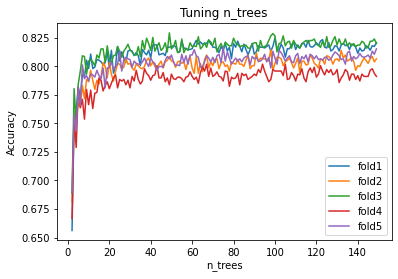

In [28]:
accs = np.zeros((148, 5))
for n in tqdm(range(2,150)):
    rf = RandomForestClassifier(n_estimators= n)
    cv_results = cross_validate(rf, X, y)
    accs[n-2] = cv_results['test_score']
    
plt.plot(range(2, 150), accs)
plt.legend(labels = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5'])
plt.title('Tuning n_trees')
plt.xlabel('n_trees')
plt.ylabel('Accuracy')

plt.show()

# Cross Validation over max_depth

In [85]:
accs = np.zeros((98, 5))
for d in tqdm(range(2,100)):
    rf = RandomForestClassifier(max_depth = d)
    cv_results = cross_validate(rf, X, y)
    accs[d-2] = cv_results['test_score']

100%|██████████| 98/98 [03:55<00:00,  2.40s/it]


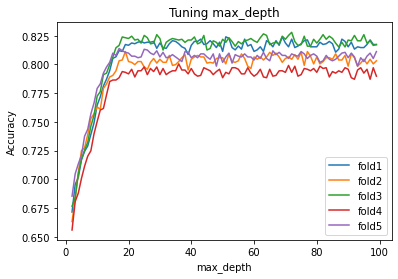

In [86]:
plt.plot(range(2, 100), accs)

plt.legend(labels = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5'])

plt.title('Tuning max_depth')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

plt.show()

# Cross Validation over Backwards Selection

In [53]:
accs = np.zeros((19, 5))
for n_feat in tqdm(range(1,20)):
    selector = RFE(RandomForestClassifier(max_depth = 26), n_features_to_select = n_feat, step=1)

    cv_results = cross_validate(selector, X, y)
    accs[n_feat-1] = cv_results['test_score']


100%|██████████| 19/19 [08:57<00:00, 28.29s/it]


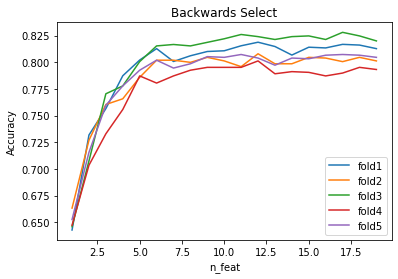

In [54]:
plt.plot(range(1, 20), accs)
plt.legend(labels = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5'])
plt.title('Backwards Select')
plt.xlabel('n_feat')
plt.ylabel('Accuracy')

plt.show()

# Generate Final Model

In [9]:
selector = RFE(RandomForestClassifier(max_depth = 26), n_features_to_select = 12, step=1)
cv_results = cross_validate(selector, X, y, return_estimator = True)
print('Training Results over Folds: ' + str(cv_results['test_score']))

Training Results over Folds: [0.8187291  0.80722892 0.83199465 0.79317269 0.8038822 ]


In [10]:
model = cv_results['estimator'][2] # 2nd fold has best accuracy

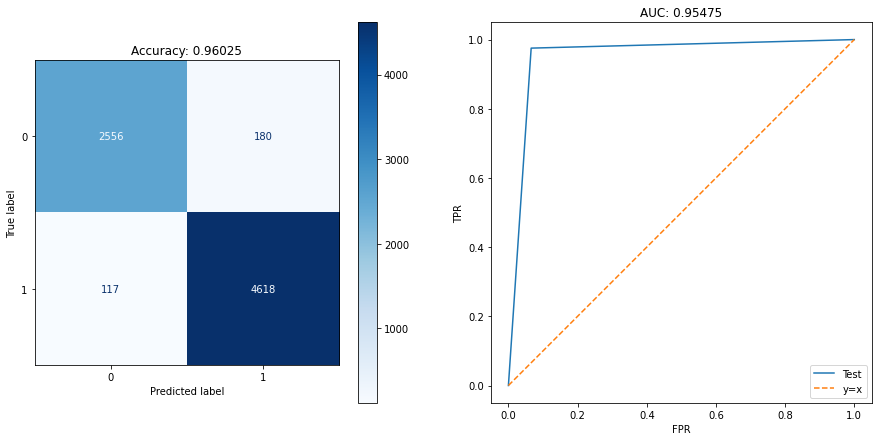

In [12]:
fig, axs = plt.subplots(1, 2, figsize = (15, 7))

test_pred = model.predict(X)
cm = confusion_matrix(y, test_pred, labels = model.classes_)#, normalize = 'true')
disp = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = model.classes_
)
disp.plot(cmap =  plt.cm.Blues, ax = axs[0])

axs[0].set(title = 'Accuracy: ' + str(round(np.sum(test_pred == y)/len(y),5)))

te_fpr, te_tpr, thresh = roc_curve(y, test_pred)

axs[1].plot(te_fpr, te_tpr)
axs[1].plot([0,1],[0,1],'--')
axs[1].legend(labels = ['Test', 'y=x'])
axs[1].set(title = 'AUC: ' + str(round(auc(te_fpr, te_tpr), 5)), 
           xlabel = 'FPR', ylabel = 'TPR')

plt.show()

### We observe a 96% accuracy when applying our trained model onto the dataset

# Predict on Test data for Kaggle

In [11]:
# Clean test data
testX = CLEAN_ALL(test, train = False)
testX = pipeline.fit_transform(testX)
pred = model.predict(testX) # make predictions

In [13]:
import csv

In [14]:
# Write predictions to CSV
with open('submission.csv', 'w') as sub:
    writer = csv.writer(sub, delimiter=',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)
    writer.writerow(['id', 'Decision'])
    for i in range(len(pred)):
        writer.writerow([int(test['id'].values[i]), pred[i]])